参考：https://tensorflow.google.cn/tutorials/keras/regression
本 notebook 使用经典的 Auto MPG 数据集，构建了一个用来预测70年代末到80年代初汽车燃油效率的模型。为了做到这一点，我们将为该模型提供许多那个时期的汽车描述。这个描述包含：气缸数，排量，马力以及重量。

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.0


### 获取数据

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 数据清洗

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

"Origin" 列为分类数据，而不是数值数据。因此，下一步是使用 pd.get_dummies 对列中的值进行独热编码。

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### 将数据拆分为训练集和测试集

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 从标签中分离特征

In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_features.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0
182,4,107.0,86.0,2464.0,15.5,76,1,0,0


### 归一化层

In [22]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [27]:
normalizer.adapt(np.array(train_features))

### 使用深度神经网络 (DNN) 进行回归

In [28]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [29]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_24 (Dense)            (None, 64)                640       
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


### 使用 DNN 和多输入进行回归

In [30]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 8.73 s
Wall time: 6.74 s


In [31]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

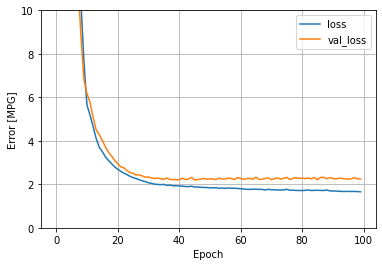

In [32]:
plot_loss(history)

In [33]:
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
print(test_results)

1.7441623210906982


### 预测

3/3 [==============================] - 0s 5ms/step


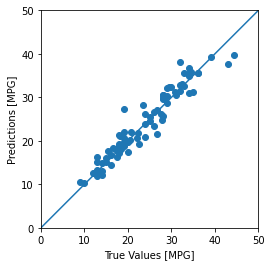

In [34]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

现在，查看一下误差分布：

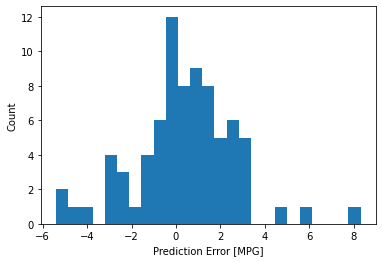

In [35]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

### 保存模型

In [36]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [37]:
reloaded = tf.keras.models.load_model('dnn_model')

In [38]:
# sample = {
#     'Cylinders': 4,
#     'Displacement': 120.0,
#     'Horsepower': 79.0,
#     'Weight': 2625.0,
#     'Acceleration': 18.6,
#     'Model Year': 82,
#     'Europe': 0,
#     'Japan': 0,
#     'USA':1
# }
sample = [[4, 120.0, 79.0, 2625.0, 18.6, 82, 0, 0, 1]]

In [40]:
reloaded.predict(sample)

1/1 [==============================] - 0s 32ms/step


array([[30.53]], dtype=float32)

### 保存模型为frozen graph

In [43]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: reloaded(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(reloaded.inputs[0].shape, reloaded.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="frozen_dnn_model.pb",
                  as_text=False)

--------------------------------------------------
Frozen model layers: 
x
sequential_8/normalization_6/sub/y
sequential_8/normalization_6/Sqrt/x
sequential_8/normalization_6/Maximum/y
sequential_8/dense_24/MatMul/ReadVariableOp/resource
sequential_8/dense_24/BiasAdd/ReadVariableOp/resource
sequential_8/dense_25/MatMul/ReadVariableOp/resource
sequential_8/dense_25/BiasAdd/ReadVariableOp/resource
sequential_8/dense_26/MatMul/ReadVariableOp/resource
sequential_8/dense_26/BiasAdd/ReadVariableOp/resource
sequential_8/normalization_6/sub
sequential_8/normalization_6/Sqrt
sequential_8/normalization_6/Maximum
sequential_8/normalization_6/truediv
sequential_8/dense_24/MatMul/ReadVariableOp
sequential_8/dense_24/MatMul
sequential_8/dense_24/BiasAdd/ReadVariableOp
sequential_8/dense_24/BiasAdd
sequential_8/dense_24/Relu
sequential_8/dense_25/MatMul/ReadVariableOp
sequential_8/dense_25/MatMul
sequential_8/dense_25/BiasAdd/ReadVariableOp
sequential_8/dense_25/BiasAdd
sequential_8/dense_25/Relu
seq

'./frozen_models\\frozen_dnn_model.pb'

In [44]:
def wrap_frozen_graph(graph_def, inputs, outputs, print_graph=False):
    def _imports_graph_def():
        tf.compat.v1.import_graph_def(graph_def, name="")

    wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
    import_graph = wrapped_import.graph

    print("-" * 50)
    print("Frozen model layers: ")
    layers = [op.name for op in import_graph.get_operations()]
    if print_graph == True:
        for layer in layers:
            print(layer)
    print("-" * 50)

    return wrapped_import.prune(
        tf.nest.map_structure(import_graph.as_graph_element, inputs),
        tf.nest.map_structure(import_graph.as_graph_element, outputs))

In [47]:
 # Load frozen graph using TensorFlow 1.x functions
with tf.io.gfile.GFile("./frozen_models/frozen_dnn_model.pb", "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    loaded = graph_def.ParseFromString(f.read())

# Wrap frozen graph to ConcreteFunctions
frozen_func = wrap_frozen_graph(graph_def=graph_def,
                                inputs=["x:0"],
                                outputs=["Identity:0"],
                                print_graph=True)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Get predictions for test images
frozen_graph_predictions = frozen_func(x=tf.constant(sample))

# Print the prediction for the first image
print("-" * 50)
print("Example TensorFlow frozen graph prediction reference:")
print(frozen_graph_predictions)

--------------------------------------------------
Frozen model layers: 
x
sequential_8/normalization_6/sub/y
sequential_8/normalization_6/Sqrt/x
sequential_8/normalization_6/Maximum/y
sequential_8/dense_24/MatMul/ReadVariableOp/resource
sequential_8/dense_24/BiasAdd/ReadVariableOp/resource
sequential_8/dense_25/MatMul/ReadVariableOp/resource
sequential_8/dense_25/BiasAdd/ReadVariableOp/resource
sequential_8/dense_26/MatMul/ReadVariableOp/resource
sequential_8/dense_26/BiasAdd/ReadVariableOp/resource
sequential_8/normalization_6/sub
sequential_8/normalization_6/Sqrt
sequential_8/normalization_6/Maximum
sequential_8/normalization_6/truediv
sequential_8/dense_24/MatMul/ReadVariableOp
sequential_8/dense_24/MatMul
sequential_8/dense_24/BiasAdd/ReadVariableOp
sequential_8/dense_24/BiasAdd
sequential_8/dense_24/Relu
sequential_8/dense_25/MatMul/ReadVariableOp
sequential_8/dense_25/MatMul
sequential_8/dense_25/BiasAdd/ReadVariableOp
sequential_8/dense_25/BiasAdd
sequential_8/dense_25/Relu
seq